In [12]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 11 15:14:28 2019

@author: Ethan
"""

# -*- coding: utf-8 -*-
"""
Created on Mon Apr  8 17:49:10 2019

@author: Ethan
"""

exec(open("../util/setupConsole.py").read())

import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import el_find_best_runoff_dist
import scipy.stats as st
import pickle, gzip
import sys, os

import warnings
warnings.filterwarnings('ignore')


#dataDir = '/dartfs-hpc/rc/lab/C/CMIG'
#dataDir = 'e:/data/'
dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/electricity'

plotFigs = False

runoffModel = 'grdc'

qstr = '-qdistfit-best'

mdlPrc = 50

models = ['bcc-csm1-1-m', 'canesm2', \
              'ccsm4', 'cesm1-bgc', 'cesm1-cam5', 'cnrm-cm5', 'csiro-mk3-6-0', \
              'gfdl-esm2g', 'gfdl-esm2m', \
              'inmcm4', 'miroc5', 'miroc-esm', \
              'mpi-esm-mr', 'mri-cgcm3', 'noresm1-m']

qsVar = 'qsGrdcAnom'
entsoeQsVar = 'qsGrdcAnom'

if not 'eData' in locals():
    eData = {}
    with open('%s/script-data/eData.dat'%dataDirDiscovery, 'rb') as f:
        eData = pickle.load(f)

nukePlants = eData['nukePlantDataAll']
nukeData = eData['nukeAgDataAll']
entsoePlants = eData['entsoePlantDataAll']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# load temp-runoff outage models
pcModel10 = []
pcModel50 = []
pcModel90 = []
plantIds = []
plantYears = []
with gzip.open('%s/script-data/pPolyData-%s-pow2.dat'%(dataDirDiscovery, runoffModel), 'rb') as f:
    pPolyData = pickle.load(f)
    # these are mislabeled in dict for now (90 is 10, 10 is 90)
    pcModel10 = pPolyData['pcModel10'][0]
    pcModel50 = pPolyData['pcModel50'][0]
    pcModel90 = pPolyData['pcModel90'][0]
    plantIds = pPolyData['plantIds']
    plantYears = pPolyData['plantYears']
    plantCooling = pPolyData['plantCooling']
    plantFuel = pPolyData['plantFuel']
    plantAge = pPolyData['plantAge']

if mdlPrc == 10:
    pcModel = pcModel10
elif mdlPrc == 50:
    pcModel = pcModel50
elif mdlPrc == 90:
    pcModel = pcModel90
    
uniquePlants = np.unique(plantIds)
    
# find historical monthly mean qs and tx for plants
qsAnomMonthlyMean = []
txMonthlyMean = []
txMonthlyMax = []


print('loading historical temp/runoff data')
# first for entsoe plants....
for p in range(entsoePlants['tx'].shape[0]):
    plantMonthlyTxMean = []
    plantMonthlyTxMax = []
    plantMonthlyQsAnomMean = []
    
    for m in range(1, 13):
        ind = np.where(entsoePlants['months'] == m)[0]
        plantMonthlyTxMean.append(np.nanmean(entsoePlants['tx'][p, ind]))
        plantMonthlyQsAnomMean.append(np.nanmean(entsoePlants[entsoeQsVar][p][ind]))
    
    qsAnomMonthlyMean.append(plantMonthlyQsAnomMean)
    txMonthlyMean.append(plantMonthlyTxMean)
    
    for m in range(0,12):
        plantMonthlyTxMax.append([])
        for y in np.unique(entsoePlants['years']):
            ind = np.where((entsoePlants['years']==y) & (entsoePlants['months']==(m+1)))[0]
            plantMonthlyTxMax[m].append(np.nanmax(entsoePlants['tx'][p][ind]))

    txMonthlyMax.append(np.nanmean(np.array(plantMonthlyTxMax), axis=1))

# then for nuke plants
for p in range(nukePlants[qsVar].shape[0]):
    plantMonthlyTxMean = []
    plantMonthlyTxMax = []
    plantMonthlyQsAnomMean = []
    
    for m in range(1,13):
        ind = np.where((nukePlants['plantMonthsAll'][p]==m))[0]
        plantMonthlyTxMean.append(np.nanmean(nukePlants['tx'][p][ind]))
        plantMonthlyQsAnomMean.append(np.nanmean(nukePlants[qsVar][p][ind]))

    qsAnomMonthlyMean.append(plantMonthlyQsAnomMean)
    txMonthlyMean.append(plantMonthlyTxMean)
    
    for m in range(0,12):
        plantMonthlyTxMax.append([])
        for y in np.unique(nukePlants['plantYearsAll'][p]):
            ind = np.where((nukePlants['plantYearsAll'][p]==y) & (nukePlants['plantMonthsAll'][p]==(m+1)))[0]
            plantMonthlyTxMax[m].append(np.nanmax(nukePlants['tx'][p][ind]))

    txMonthlyMax.append(np.nanmean(np.array(plantMonthlyTxMax), axis=1))

qsAnomMonthlyMean = np.array(qsAnomMonthlyMean)
txMonthlyMean = np.array(txMonthlyMean)
txMonthlyMax = np.array(txMonthlyMax)

t0 = 27
q0 = 0

dfpred = pd.DataFrame({'T1':[t0]*len(plantIds), 'T2':[t0**2]*len(plantIds), \
                         'QS1':[q0]*len(plantIds), 'QS2':[q0**2]*len(plantIds), \
                         'QST':[t0*q0]*len(plantIds), 'QS2T2':[(t0**2)*(q0**2)]*len(plantIds), \
                         'PlantIds':plantIds, 'PlantYears':plantYears})
pc0 = np.nanmean(pcModel.predict(dfpred))


plantTxDataNcepR2 = np.genfromtxt('%s/script-data/entsoe-nuke-pp-tx-ncep-r2-1981-2005.csv'%dataDirDiscovery, delimiter=',')
plantTxDataNcepR2Years = plantTxDataNcepR2[0,:]
plantTxDataNcepR2Months = plantTxDataNcepR2[1,:]
plantTxDataNcepR2 = plantTxDataNcepR2[2:,:]

plantTxData = np.genfromtxt('%s/script-data/entsoe-nuke-pp-tx-1981-2018.csv'%dataDirDiscovery, delimiter=',')
plantTxDataYears = plantTxData[0,:]
plantTxDataMonths = plantTxData[1,:]
plantTxData = plantTxData[3:,:]

plantTxDataPreInd = np.genfromtxt('%s/script-data/entsoe-nuke-pp-tx-20cr-1850-1900.csv'%dataDirDiscovery, delimiter=',')
plantTxDataPreIndYears = plantTxDataPreInd[0,:]
plantTxDataPreIndMonths = plantTxDataPreInd[1,:]
plantTxDataPreInd = plantTxDataPreInd[2:,:]

plantQsData = np.genfromtxt('%s/script-data/entsoe-nuke-pp-runoff-anom-gldas-1981-2018.csv'%dataDirDiscovery, delimiter=',')
plantQsDataYears = plantQsData[0,:]
plantQsDataMonths = plantQsData[1,:]
plantQsData = plantQsData[3:,:]

plantQsData[plantQsData < -5] = np.nan
plantQsData[plantQsData > 5] = np.nan


loading historical temp/runoff data


PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'PlantCooling' is not defined
    PC ~ T1 + T2 + QS1 + QS2 + QST + QS2T2 + C(PlantIds) + C(PlantYears) + C(PlantCooling) + C(PlantFuel)
                                                                           ^^^^^^^^^^^^^^^

In [4]:
txMonthlyMax = np.full([plantTxData.shape[0], 12], np.nan)
txMonthlyMaxNcepR2 = np.full([plantTxDataNcepR2.shape[0], 12], np.nan)
txMonthlyMaxPreInd = np.full([plantTxDataPreInd.shape[0], 12], np.nan)
qsAnomMonthlyMean = np.full([plantTxData.shape[0], 12], np.nan)
qsAnomMonthlyMeanNcepR2 = np.full([plantTxDataNcepR2.shape[0], 12], np.nan)
qsAnomMonthlyMeanPreInd = np.full([plantTxDataPreInd.shape[0], 12], np.nan)

for month in range(1, 13):
    curMonthlyMaxTx = np.full([plantTxData.shape[0], len(np.unique(plantTxDataYears))], np.nan)
    curMonthlyMaxTxNcepR2 = np.full([plantTxDataNcepR2.shape[0], len(np.unique(plantTxDataNcepR2Years))], np.nan)
    curMonthlyMaxTxPreInd = np.full([plantTxDataPreInd.shape[0], len(np.unique(plantTxDataPreIndYears))], np.nan)
    
    curMonthlyMeanQs = np.full([plantTxData.shape[0], len(np.unique(plantTxDataYears))], np.nan)
    curMonthlyMeanQsNcepR2 = np.full([plantTxDataNcepR2.shape[0], len(np.unique(plantTxDataNcepR2Years))], np.nan)
    curMonthlyMeanQsPreInd = np.full([plantTxDataPreInd.shape[0], len(np.unique(plantTxDataPreIndYears))], np.nan)
    
    for y, year in enumerate(np.unique(plantTxDataYears)):
        ind = np.where((plantTxDataYears == year) & (plantTxDataMonths == month))[0]
        
        # find monthly max
        curMonthlyMaxTx[:, y] = np.nanmax(plantTxData[:, ind], axis=1)
        curMonthlyMeanQs[:, y] = np.nanmean(plantQsData[:, ind], axis=1)
    
    for y, year in enumerate(np.unique(plantTxDataNcepR2Years)):
        indTx = np.where((plantTxDataNcepR2Years == year) & (plantTxDataNcepR2Months == month))[0]
        indQs = np.where((plantQsDataYears == year) & (plantQsDataMonths == month))[0]
        
        # these are already monthly max, so just take single value
        curMonthlyMaxTxNcepR2[:, y] = plantTxDataNcepR2[:, indTx[0]]
        
        # but find monthly mean from qs data
        curMonthlyMeanQsNcepR2[:, y] = np.nanmean(plantQsData[:, indQs], axis=1)
    
    for y, year in enumerate(np.unique(plantTxDataPreIndYears)):
        # these are already monthly max so just take single value for month/year
        # also use the historical (1981-2018) monthly mean runoff
        indTx = np.where((plantTxDataPreIndYears == year) & (plantTxDataPreIndMonths == month))[0]
        curMonthlyMaxTxPreInd[:, y] = plantTxDataPreInd[:, indTx[0]]
    
    txMonthlyMax[:, month-1] = np.nanmean(curMonthlyMaxTx, axis=1)
    txMonthlyMaxNcepR2[:, month-1] = np.nanmean(curMonthlyMaxTxNcepR2, axis=1)
    txMonthlyMaxPreInd[:, month-1] = np.nanmean(curMonthlyMaxTxPreInd, axis=1)
    qsAnomMonthlyMean[:, month-1] = np.nanmean(curMonthlyMeanQs, axis=1)
    qsAnomMonthlyMeanPreInd[:, month-1] = np.nanmean(curMonthlyMeanQs, axis=1)
    qsAnomMonthlyMeanNcepR2[:, month-1] = np.nanmean(curMonthlyMeanQsNcepR2, axis=1)



In [5]:
print('calculating historical (1981-2018) pc')
pcHist = np.full([txMonthlyMax.shape[0], 12], np.nan)
for p in range(txMonthlyMax.shape[0]):
    if p%10 == 0:
        print('plant %d of %d'%(p, txMonthlyMax.shape[0]))
        
    for month in range(0,12):
        t1 = txMonthlyMax[p,month]
        q1 = qsAnomMonthlyMean[p,month]

        # if > 27 C 
        if t1 >= t0 and ~np.isnan(q1):
            dfpred = pd.DataFrame({'T1':[t1]*len(plantIds), 'T2':[t1**2]*len(plantIds), \
                 'QS1':[q1]*len(plantIds), 'QS2':[q1**2]*len(plantIds), \
                 'QST':[t1*q1]*len(plantIds), 'QS2T2':[(t1**2)*(q1**2)]*len(plantIds), \
                 'PlantIds':plantIds, 'PlantYears':plantYears})
            pc1 = np.nanmean(pcModel.predict(dfpred))

            if pc1 > 100: pc1 = 100
            if pc1 < 0: pc1 = 0

            outage = pc1-pc0
            if outage > 0: outage = 0
            pcHist[p,month] = outage
            
        elif t1 < t0 and ~np.isnan(q1):
            pcHist[p,month] = 0

            

calculating historical (1981-2018) pc
plant 0 of 113
plant 10 of 113
plant 20 of 113
plant 30 of 113
plant 40 of 113
plant 50 of 113
plant 60 of 113
plant 70 of 113
plant 80 of 113
plant 90 of 113
plant 100 of 113
plant 110 of 113


In [6]:
print('calculating historical (1981-2005) pc with NCEP R2')
pcHistNcepR2 = np.full([txMonthlyMaxNcepR2.shape[0], 12], np.nan)
for p in range(txMonthlyMaxNcepR2.shape[0]):
    if p%10 == 0:
        print('plant %d of %d'%(p, txMonthlyMaxNcepR2.shape[0]))
        
    for month in range(0,12):
        t1 = txMonthlyMaxNcepR2[p,month]
        q1 = qsAnomMonthlyMeanNcepR2[p,month]

        # if > 27 C 
        if t1 >= t0 and ~np.isnan(q1):
            dfpred = pd.DataFrame({'T1':[t1]*len(plantIds), 'T2':[t1**2]*len(plantIds), \
                 'QS1':[q1]*len(plantIds), 'QS2':[q1**2]*len(plantIds), \
                 'QST':[t1*q1]*len(plantIds), 'QS2T2':[(t1**2)*(q1**2)]*len(plantIds), \
                 'PlantIds':plantIds, 'PlantYears':plantYears})
            pc1 = np.nanmean(pcModel.predict(dfpred))

            if pc1 > 100: pc1 = 100
            if pc1 < 0: pc1 = 0

            outage = pc1-pc0
            if outage > 0: outage = 0
            pcHistNcepR2[p,month] = outage
            
        elif t1 < t0 and ~np.isnan(q1):
            pcHistNcepR2[p,month] = 0
        

calculating historical (1981-2005) pc with NCEP R2
plant 0 of 113
plant 10 of 113
plant 20 of 113
plant 30 of 113
plant 40 of 113
plant 50 of 113
plant 60 of 113
plant 70 of 113
plant 80 of 113
plant 90 of 113
plant 100 of 113
plant 110 of 113


In [7]:
print('calculating pre-industrial (1850-1900) pc')
pcPreInd = np.full([txMonthlyMaxPreInd.shape[0], 12], np.nan)
for p in range(txMonthlyMaxPreInd.shape[0]):
    
    if p%10 == 0:
        print('plant %d of %d'%(p, txMonthlyMaxPreInd.shape[0]))
        
    for month in range(0,12):

        t1 = txMonthlyMaxPreInd[p,month]
        q1 = qsAnomMonthlyMeanPreInd[p,month]

        # if > 27 C 
        if t1 >= t0 and ~np.isnan(q1):

            dfpred = pd.DataFrame({'T1':[t1]*len(plantIds), 'T2':[t1**2]*len(plantIds), \
                 'QS1':[q1]*len(plantIds), 'QS2':[q1**2]*len(plantIds), \
                 'QST':[t1*q1]*len(plantIds), 'QS2T2':[(t1**2)*(q1**2)]*len(plantIds), \
                 'PlantIds':plantIds, 'PlantYears':plantYears})
            pc1 = np.nanmean(pcModel.predict(dfpred))

            if pc1 > 100: pc1 = 100
            if pc1 < 0: pc1 = 0

            outage = pc1-pc0
            if outage > 0: outage = 0
            pcPreInd[p,month] = outage
            
        elif t1 < t0 and ~np.isnan(q1):
            pcPreInd[p,month] = 0

            

calculating pre-industrial (1850-1900) pc
plant 0 of 113
plant 10 of 113
plant 20 of 113
plant 30 of 113
plant 40 of 113
plant 50 of 113
plant 60 of 113
plant 70 of 113
plant 80 of 113
plant 90 of 113
plant 100 of 113
plant 110 of 113


In [8]:
if os.path.isfile('%s/script-data/ppFutureTxQsData-preIndRef.dat'%dataDirDiscovery):
    
    with gzip.open('%s/script-data/ppFutureTxQsData-preIndRef.dat'%dataDirDiscovery, 'rb') as f:
        ppFutureData = pickle.load(f)
        txMonthlyMeanFutGMT = ppFutureData['txMonthlyMeanFutGMT']
        txMonthlyMaxFutGMT = ppFutureData['txMonthlyMaxFutGMT']
        qsMonthlyMeanFutGMT = ppFutureData['qsMonthlyMeanFutGMT']
else:
    print('loading future gmt temp/runoff data')
    # load future mean warming data for GMT levels

    # load future mean warming data and recompute PC
    txMonthlyMeanFutGMT = np.full([4, len(models), txMonthlyMax.shape[0], 12], np.nan)
    txMonthlyMaxFutGMT = np.full([4, len(models), txMonthlyMax.shape[0], 12], np.nan)
    qsMonthlyMeanFutGMT = np.full([4, len(models), txMonthlyMax.shape[0], 12], np.nan)

    for w in range(1, 4+1):

        for m in range(len(models)):

            print('processing %s/%d'%(models[m],w))


            # load data for current model and warming level
            fileNameTemp = '%s/gmt-anomaly-temps/entsoe-nuke-pp-%ddeg-tx-cmip5-%s-preIndRef.csv'%(dataDirDiscovery, w, models[m])

            if not os.path.isfile(fileNameTemp):
                print('no temp file: %s'%fileNameTemp)
                continue

            plantTxData = np.genfromtxt(fileNameTemp, delimiter=',', skip_header=0)

            if len(plantTxData) == 0:
                print('temp data empty: %s'%fileNameTemp)
                continue

            plantTxYearData = plantTxData[0,1:].copy()
            plantTxMonthData = plantTxData[1,1:].copy()
            plantTxDayData = plantTxData[2,1:].copy()
            plantTxData = plantTxData[3:,1:].copy()

            fileNameRunoffRaw = '%s/gmt-anomaly-temps/entsoe-nuke-pp-%ddeg-runoff-raw-cmip5-%s-preIndRef.csv'%(dataDirDiscovery, w, models[m])
            fileNameRunoffDistFit = '%s/gmt-anomaly-temps/entsoe-nuke-pp-%ddeg-runoff%s-cmip5-%s-preIndRef.csv'%(dataDirDiscovery, w, qstr, models[m])

            plantQsAnomData = []

            # if the anomalies exist, load them
            if os.path.isfile(fileNameRunoffDistFit):

                plantQsData = np.genfromtxt(fileNameRunoffDistFit, delimiter=',', skip_header=0)

            elif os.path.isfile(fileNameRunoffRaw):
                # if the anomalies don't exist, first we need to find the best fit dist for this model/plant if it hasn't already been done,
                # then use that best fit to calculate the anomalies and save them

                fileNameRunoffHist = '%s/future-temps/entsoe-nuke-pp-hist-runoff-raw-cmip5-%s-1981-2005.csv'%(dataDirDiscovery, models[m])
                plantQsDataHistCmip5 = np.genfromtxt(fileNameRunoffHist, delimiter=',', skip_header=0)

                for p in range(plantQsDataHistCmip5.shape[0]):
                    # first 52 plants are entsoe
                    if p <= 51:
                        entsoePlantId = p
                        if not os.path.isfile('%s/dist-fits/best-fit-entsoe-hist-cmip5-%s-plant-%d.dat'%(dataDirDiscovery, models[m], entsoePlantId)):
                            nn = np.where(~np.isnan(plantQsDataHistCmip5[p,:]))[0]
                            best_fit_name, best_fit_params, curQsStd = el_find_best_runoff_dist.best_fit_distribution(plantQsDataHistCmip5[p,nn])
                            with open('%s/dist-fits/best-fit-entsoe-hist-cmip5-%s-plant-%d.dat'%(dataDirDiscovery, models[m], entsoePlantId), 'wb') as f:
                                dist = getattr(st, best_fit_name)
                                tmpQsPercentile = dist.cdf(plantQsDataHistCmip5[p,nn], *best_fit_params)
                                distParams = {'name':best_fit_name,
                                              'params':best_fit_params, 
                                              'std':curQsStd,
                                              'cdf':tmpQsPercentile}
                                pickle.dump(distParams, f)
                                print('cmip5 hist entsoe %d/%s: dist = %s, std = %.4f'%(entsoePlantId, models[m], str(dist), curQsStd))
                        else:
                            with open('%s/dist-fits/best-fit-entsoe-hist-cmip5-%s-plant-%d.dat'%(dataDirDiscovery, models[m], entsoePlantId), 'rb') as f:
                                distParams = pickle.load(f)
                                curQsStd = distParams['std']


                    # plant 53 and on are nuke
                    elif p >= 52:
                        nukePlantId = p
                        if not os.path.isfile('%s/dist-fits/best-fit-nuke-hist-cmip5-%s-plant-%d.dat'%(dataDirDiscovery, models[m], nukePlantId)):
                            nn = np.where(~np.isnan(plantQsDataHistCmip5[p,:]))[0]
                            best_fit_name, best_fit_params, curQsStd = el_find_best_runoff_dist.best_fit_distribution(plantQsDataHistCmip5[p,nn])
                            with open('%s/dist-fits/best-fit-nuke-hist-cmip5-%s-plant-%d.dat'%(dataDirDiscovery, models[m], nukePlantId), 'wb') as f:
                                dist = getattr(st, best_fit_name)
                                tmpQsPercentile = dist.cdf(plantQsDataHistCmip5[p,nn], *best_fit_params)
                                distParams = {'name':best_fit_name,
                                              'params':best_fit_params, 
                                              'std':curQsStd,
                                              'cdf':tmpQsPercentile}
                                pickle.dump(distParams, f)
                                print('cmip5 hist nuke %d/%s: std = %.4f'%(nukePlantId, models[m], curQsStd))
                        else:
                            with open('%s/dist-fits/best-fit-nuke-hist-cmip5-%s-plant-%d.dat'%(dataDirDiscovery, models[m], nukePlantId), 'rb') as f:
                                distParams = pickle.load(f)
                                curQsStd = distParams['std']


                    # now load the raw cmip5 gmt change data and find its anom using the best-fit dist from above
                    plantQsData = np.genfromtxt(fileNameRunoffRaw, delimiter=',', skip_header=0)

                    # add year/month/day rows first
                    if p == 0:
                        plantQsAnomData.append(plantQsData[0,:])
                        plantQsAnomData.append(plantQsData[1,:])
                        plantQsAnomData.append(plantQsData[2,:])

                    qAnom = (plantQsData[p+3,:] - np.nanmean(plantQsData[p+3,:])) / curQsStd
                    plantQsAnomData.append(qAnom)

                # now we have computed anoms for all plants, save the anom file for this model
                plantQsAnomData = np.array(plantQsAnomData)
                np.savetxt(fileNameRunoffDistFit, plantQsAnomData, delimiter=',')
                plantQsData = plantQsAnomData[3:,:]

            else:
                # neither raw nor anom runoff file exists
                print("runoff file doesn't exist: %s"%fileNameRunoffDistFit)
                continue

            if len(plantQsData) == 0:
                print('runoff data empty: %s'%fileNameRunoffDistFit)
                continue

            plantQsYearData = plantTxData[0,1:].copy()
            plantQsMonthData = plantTxData[1,1:].copy()
            plantQsDayData = plantTxData[2,1:].copy()

            # loop over all plants
            for p in range(plantTxData.shape[0]):

                plantTxMonthlyMeanGMT = np.full([len(range(int(min(plantTxYearData)), int(max(plantTxYearData))+1)), 12], np.nan)
                plantTxMonthlyMaxGMT = np.full([len(range(int(min(plantTxYearData)), int(max(plantTxYearData))+1)), 12], np.nan)
                plantQsMonthlyMeanGMT = np.full([len(range(int(min(plantTxYearData)), int(max(plantTxYearData))+1)), 12], np.nan)

                # tx,qs for current plant
                tx = plantTxData[p, :]
                qs = plantQsData[p, :]

                # loop over all years for current model/GMT anomaly
                for yearInd, year in enumerate(range(int(min(plantTxYearData)), int(max(plantTxYearData))+1)):

                    # and over all months
                    for month in range(1, 13):

                        # tx for current year's current month
                        ind = np.where((plantTxYearData == year) & (plantTxMonthData == month))[0]

                        curTx = tx[ind]
                        curQs = qs[ind]

                        nn = np.where((~np.isnan(curTx)) & (~np.isnan(curQs)))[0]

                        if len(nn) == 0:
                            continue

                        curTx = curTx[nn]
                        curQs = curQs[nn]

                        # ind of the txx day in this year/month
                        indTxx = np.where(curTx == np.nanmax(curTx))[0][0]

                        curTxx = curTx[indTxx]
                        curQsTxx = curQs[indTxx]

                        plantTxMonthlyMeanGMT[yearInd, month-1] = np.nanmean(curTx)
                        plantTxMonthlyMaxGMT[yearInd, month-1] = curTxx
                        plantQsMonthlyMeanGMT[yearInd, month-1] = np.nanmean(curQs)

                txMonthlyMeanFutGMT[w-1, m, p, :] = np.nanmean(np.array(plantTxMonthlyMeanGMT), axis=0)
                txMonthlyMaxFutGMT[w-1, m, p, :] = np.nanmean(np.array(plantTxMonthlyMaxGMT), axis=0)
                qsMonthlyMeanFutGMT[w-1, m, p, :] = np.nanmean(np.array(plantQsMonthlyMeanGMT), axis=0)

        qsMonthlyMeanFutGMT[qsMonthlyMeanFutGMT>3] = np.nan
        qsMonthlyMeanFutGMT[qsMonthlyMeanFutGMT<-3] = np.nan


    ppFutureData = {'txMonthlyMeanFutGMT':txMonthlyMeanFutGMT, \
                   'txMonthlyMaxFutGMT':txMonthlyMaxFutGMT, \
                   'qsMonthlyMeanFutGMT':qsMonthlyMeanFutGMT}
    with gzip.open('%s/script-data/ppFutureTxQsData-preIndRef.dat'%dataDirDiscovery, 'wb') as f:
       pickle.dump(ppFutureData, f)


In [9]:
if os.path.isfile('%s/script-data/pc-monthly-outage-chg-%s-mdl%d-preIndRef.dat'%(dataDirDiscovery, qsVar, mdlPrc)):
    with open('%s/script-data/pc-monthly-outage-chg-%s-mdl%d-preIndRef.dat'%(dataDirDiscovery, qsVar, mdlPrc), 'rb') as f:
        plantMonthlyOutageChg = pickle.load(f)
else:
    print('calculating curtailment change')
    plantMonthlyOutageChg = []

    # loop over GMT warming levels
    for w in range(0, 4):

        print('processing GMT %d'%(w+1))

        plantMonthlyOutageChgGMT = []
        # loop over all plants
        for p in range(nukePlants['qsAnom'].shape[0] + entsoePlants['tx'].shape[0]):
            curPlantMonthlyOutageChg = []

            for month in range(0,12):

                curPlantMonthlyOutageChg.append([])

                for model in range(len(models)):

                    t1 = txMonthlyMaxFutGMT[w,model,p,month]
                    q1 = qsMonthlyMeanFutGMT[w,model,p,month]

                    # if > 27 C 
                    if t1 >= t0:

                        dfpred = pd.DataFrame({'T1':[t1]*len(plantIds), 'T2':[t1**2]*len(plantIds), \
                             'QS1':[q1]*len(plantIds), 'QS2':[q1**2]*len(plantIds), \
                             'QST':[t1*q1]*len(plantIds), 'QS2T2':[(t1**2)*(q1**2)]*len(plantIds), \
                             'PlantIds':plantIds, 'PlantYears':plantYears})
                        pc1 = np.nanmean(pcModel.predict(dfpred))

                        if pc1 > 100: pc1 = 100
                        if pc1 < 0: pc1 = 0

                        outage = pc1-pc0
                        if outage > 0: outage = 0
                        curPlantMonthlyOutageChg[month].append(outage)
                    else:
                        curPlantMonthlyOutageChg[month].append(0)

            plantMonthlyOutageChgGMT.append(curPlantMonthlyOutageChg)

        plantMonthlyOutageChg.append(plantMonthlyOutageChgGMT)

    plantMonthlyOutageChg = np.array(plantMonthlyOutageChg)

    with open('%s/script-data/pc-monthly-outage-chg-%s-mdl%d-preIndRef.dat'%(dataDirDiscovery, qsVar, mdlPrc), 'wb') as f:
        pickle.dump(plantMonthlyOutageChg, f)

plantMonthlyOutageChgSorted = np.sort(np.nanmean(plantMonthlyOutageChg,axis=1),axis=2)

outageSummerWorst = np.nanmean(np.nanmean(plantMonthlyOutageChg[:,:,[6,7],:], axis=2), axis=1)
outageMonthlyFutGMT2Min = np.where(outageSummerWorst[1,:] == np.nanmin(outageSummerWorst[1,:]))[0][0]
outageMonthlyFutGMT4Min = np.where(outageSummerWorst[3,:] == np.nanmin(outageSummerWorst[3,:]))[0][0]


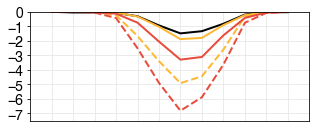

In [10]:
snsColors = sns.color_palette(["#3498db", "#e74c3c"])


fig = plt.figure(figsize=(5,2))
plt.xlim([0, 13])
plt.ylim([-7.5, 0])
# plt.ylim([-11, 0])
plt.grid(True, color=[.9,.9,.9])

#plt.plot([0, 13], [0, 0], '--k', lw=1)
# plt.plot(list(range(1,13)), np.nanmean(pcPreInd,axis=0), '-', lw=2, color=snsColors[0])
plt.plot(list(range(1,13)), np.nanmean(pcHist,axis=0), '-', lw=2, color='black')
plt.plot(list(range(1,13)), np.nanmean(np.nanmean(plantMonthlyOutageChg[1,:,:,:],axis=2),axis=0), '-', lw=2, color='#ffb835')
plt.plot(list(range(1,13)), np.nanmean(plantMonthlyOutageChg[1,:,:,outageMonthlyFutGMT2Min],axis=0), '--', lw=2, color='#ffb835')
plt.plot(list(range(1,13)), np.nanmean(np.nanmean(plantMonthlyOutageChg[3,:,:,:],axis=2),axis=0), '-', lw=2, color=snsColors[1])
plt.plot(list(range(1,13)), np.nanmean(plantMonthlyOutageChg[3,:,:,outageMonthlyFutGMT4Min],axis=0), '--', lw=2, color=snsColors[1])

plt.xticks(list(range(1,13)))
plt.yticks(np.arange(-7,1,1))

plt.xticks(list(range(1,13)))

for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontname('Helvetica')
    tick.label.set_fontsize(14)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontname('Helvetica')    
    tick.label.set_fontsize(14)

# plt.gca().spines['bottom'].set_visible(False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# plt.xlabel('Month', fontname = 'Helvetica', fontsize=16)

if plotFigs:
    plt.savefig('outage-chg-by-month-%s%s-mdl%d.eps'%(runoffModel, qstr, mdlPrc), format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)


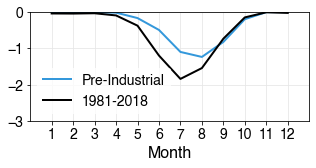

In [11]:
fig = plt.figure(figsize=(5,2))
plt.xlim([0, 13])
# plt.ylim([-8.5, 0])
plt.ylim([-3, 0])
plt.grid(True, color=[.9,.9,.9])

#plt.plot([0, 13], [0, 0], '--k', lw=1)
plt.plot(list(range(1,13)), np.nanmean(pcPreInd,axis=0), '-', lw=2, color=snsColors[0], label='Pre-Industrial')
plt.plot(list(range(1,13)), np.nanmean(pcHistNcepR2,axis=0), '-', lw=2, color='black', label='1981-2018')

plt.xticks(list(range(1,13)))
plt.yticks(np.arange(-3,1,1))

plt.xticks(list(range(1,13)))

for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontname('Helvetica')
    tick.label.set_fontsize(14)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontname('Helvetica')    
    tick.label.set_fontsize(14)

#plt.gca().spines['bottom'].set_visible(False)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off

plt.xlabel('Month', fontname = 'Helvetica', fontsize=16)

leg = plt.legend(prop = {'size':14, 'family':'Helvetica'})
leg.get_frame().set_linewidth(0.0)

if plotFigs:
    plt.savefig('outage-chg-by-month-pre-ind-vs-hist-%s%s-mdl%d.eps'%(runoffModel, qstr, mdlPrc), format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

    